# 3ML with Fermi GBM TTE Data
### Purpose
Fermi GBM data is in a format that does not lend itself to being used with standard software such as XSPEC. However, the **FermiGBMLikeTTE** in **3ML** plugin allows the user to work directly with the TTE data in its native format

**FermiGBMLikeTTE** provides the following functionality
* Reading GBM TTE data
* Proper MLE polynomial background fitting
* Pure counts and light curve plotting

It creates a standard **3ML** Model and therefore can be used like any other plugin *without* using specical tools to create PHA files.

#### Let's check it out!

Import **3ML** as always to make sure you have the plugin

In [1]:
%matplotlib inline
%matplotlib notebook
from threeML import *

get_available_plugins()

Configuration read from /Users/jburgess/.threeML/threeML_config.yml
Available plugins:

FermiGBMTTELike for Fermi GBM TTE (all detectors)
FermiLATLLELike for Fermi LAT LLE
OGIPLike for All OGIP-compliant instruments
XYLike for n.a.
EventListLike for Generic EventList data
SwiftXRTLike for Swift XRT


We will look at GRB080916C as a test case


**FermiGBM_TTE_Like** takes as arguments:
* a name
* the TTE file name
* background intervals separated by commas
* an inital source interval to fit
* the correct RSP file
* (optional) a polynomial order for background fitting *(0-4)*

**FermiGBM_TTE_Like** will attempt to find the best background polynomial order via a LRT.
The background is fit with an Poisson likehood via method developed by Giacomo V. 

In [2]:
# os.path.join is a way to generate system-independent
# paths (good for unix, windows, Mac...)

data_dir = os.path.join('gbm','bn080916009')
trigger_number = 'bn080916009'

# Download the data

data_dir_gbm = os.path.join('gbm',trigger_number)
gbm_data = download_GBM_trigger_data(trigger_number,detectors=['n3','n4','b0'],
                                     destination_directory=data_dir_gbm,compress_tte=True)




src_selection = "0.-71."


# We start out with a bad background interval to demonstrate a few features

nai3 = FermiGBMTTELike('NAI3',
                       os.path.join(data_dir, "glg_tte_n3_bn080916009_v01.fit.gz"),
                       os.path.join(data_dir, "glg_cspec_n3_bn080916009_v00.rsp2"),
                       src_selection,
                        "-10-0,50-200", # setting this badly on purpose!
                       poly_order=2)

nai4 = FermiGBMTTELike('NAI4',
                       os.path.join(data_dir_gbm, "glg_tte_n4_bn080916009_v01.fit.gz"),
                       os.path.join(data_dir_gbm, "glg_cspec_n4_bn080916009_v00.rsp2"),
                       src_selection,
                       "-10-0,120-200",
                       poly_order=-1,
                      verbose=False)

bgo0 = FermiGBMTTELike('BGO0',
                       os.path.join(data_dir, "glg_tte_b0_bn080916009_v01.fit.gz"),
                       os.path.join(data_dir, "glg_cspec_b0_bn080916009_v00.rsp2"),
                        src_selection,
                       "-10-0,100-200")


WARNING UserWarning: No TLMIN keyword found. This DRM does not follow OGIP standards. Assuming TLMIN=1


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy



Unbinned 2-order polynomial fit with the Nelder-Mead method


Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Minimum MC energy is larger than minimum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Minimum MC energy is larger than minimum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Minimum MC energy is larger than minimum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Minimum MC energy is larger than minimum EBOUNDS energy



Auto-determined polynomial order: 1


Unbinned 1-order polynomial fit with the Nelder-Mead method


Auto-probed noise models:
- observation: poisson
- background: gaussian


You will get a warning about GBM DRMS because they lack the keyword to indicate the first channel of the DRM. It is ok because the normal choice is 1

The TTE class build upon the generic EventList class which can be used to get some information on or selections.

If you are connected to the internet, timing information for other instruments can be obtained:



In [3]:
nai3

n. channels                                                            128
total rate                                                         1859.82
total bkg. rate                                                    1374.04
total bkg. rate error                                              5.82614
exposure                                                           70.7366
bkg. exposure                                                      70.7366
significance                                                        63.607
is poisson                                                            True
bkg. is poisson                                                      False
response                 gbm/bn080916009/glg_cspec_n3_bn080916009_v00.rsp2
active selection (1)           time interval 0.0 - 71.0 (duration: 71.0)
active deadtime                                                 0.263402
polynomial selection (1)      time interval -10.0 - 0.0 (duration: 10.0)
polynomial selection (2)    tim

The information from the background fit polynomials is available as a pandas Panel <['coefficients'] and ['error']>

In [4]:
res = nai3.get_background_parameters()

Coefficients


,0,1,2
0,7.846756,-0.001909,-0.000012
1,6.296577,0.000566,0.000015
2,8.166759,-0.014130,0.000035
3,8.959902,0.011904,-0.000091
4,11.610133,0.001976,-0.000060
5,15.778345,-0.003290,-0.000056
6,20.580273,0.052230,-0.000316
7,22.402665,0.063452,-0.000353
8,29.252185,-0.010730,-0.000023
9,30.224825,0.012449,-0.000176


Coefficient Error


,0,1,2
0,0.759943,0.014344,0.000065
1,0.681068,0.013197,0.000061
2,0.785819,0.014763,0.000066
3,0.836521,0.015853,0.000071
4,0.926455,0.017671,0.000080
5,1.086569,0.020474,0.000092
6,1.263082,0.024148,0.000109
7,1.301859,0.024995,0.000114
8,1.458824,0.027744,0.000126
9,1.495010,0.028543,0.000130


Let's look at the lightcurve of NAI3 to check out background fit:

<IPython.core.display.Javascript object>


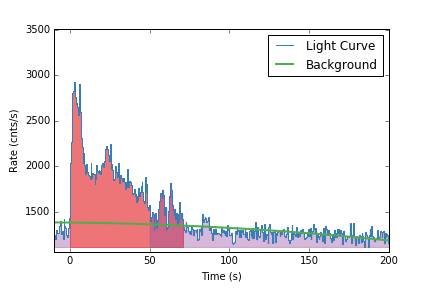

In [5]:
nai3.view_lightcurve(-10,200.,.5)

Oy! That is not so nice! Luckily, we can simply select another interval!

We can set the background polynomial order ourself, or use LRT to decide which order is best. If the order is set to -1, then it is automatically determined. Setting the order will initiate a refit of the background using the last imput background interval selections.

In [6]:
nai3.set_background_interval("-10.--1.","120-200") # You can select as many as required!

Unbinned 2-order polynomial fit with the Nelder-Mead method


Auto-probed noise models:
- observation: poisson
- background: gaussian


Refitting background with new polynomial order (-1) and existing selections
Auto-determined polynomial order: 1


Unbinned 1-order polynomial fit with the Nelder-Mead method




<IPython.core.display.Javascript object>


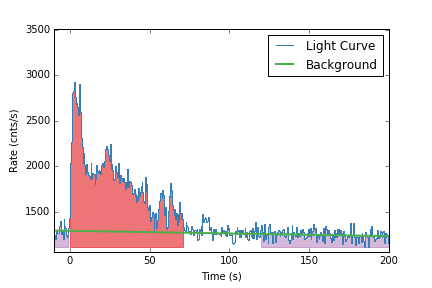

In [7]:
nai3.background_poly_order = -1 # Auto determine!

nai3.view_lightcurve(-10,200.,.5)

It is also possible to select multiple (disjoint only) src intervals


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy



Auto-probed noise models:
- observation: poisson
- background: gaussian


<IPython.core.display.Javascript object>


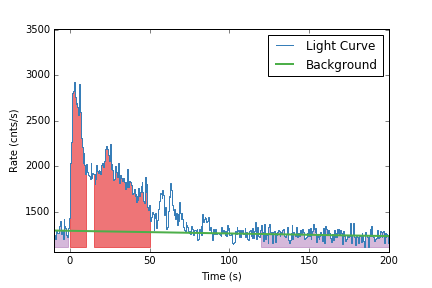

In [8]:
nai3.set_active_time_interval('0-10','15-50')

nai3.view_lightcurve(-10,200.,.5)

Selecting non-disjoint intervals will result in the intervals being merged into one:


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy



Auto-probed noise models:
- observation: poisson
- background: gaussian


<IPython.core.display.Javascript object>


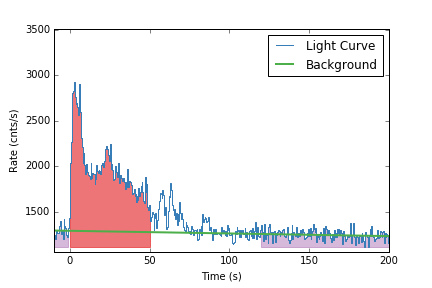

In [9]:
nai3.set_active_time_interval('0-10','5-50')
nai3.view_lightcurve(-10,200.,.5)

In [10]:
# go back to our original selection
nai3.set_active_time_interval(src_selection)

Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy



If we want to examine the light curve in different energy ranges, we can supply an argument:

<IPython.core.display.Javascript object>


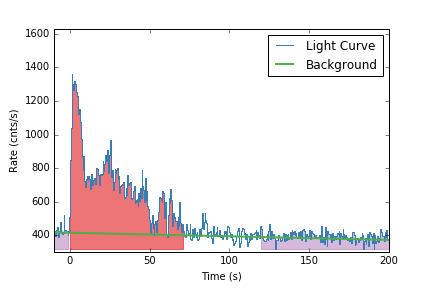

In [11]:
nai3.view_lightcurve(-10,200.,.5,energy_selection='50-300')

<IPython.core.display.Javascript object>


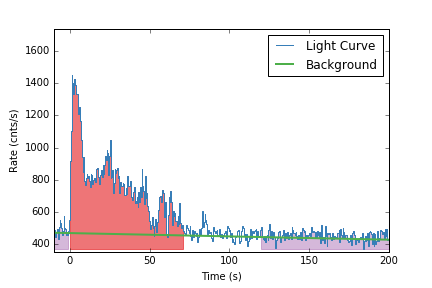

In [12]:
nai3.view_lightcurve(-10,200.,.5,energy_selection='50-300, 500-900')

### Energy selection

We need to select the energies we would like to fit over. GBM has over/underflow channels which must be exlcuded from the fit. This is not always at the same energy, so we need to check.
**FermiGBM_TTE_Like**  (and **FermiGBMLike** ) allow you to plot the count spectra so you can see what you will be excluding in the fit.

Range 10.0-30.0 translates to channels 6-21
Range 40.0-900.0 translates to channels 27-124
Now using 114 channels out of 128


<IPython.core.display.Javascript object>


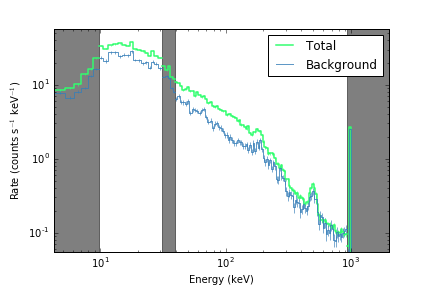

In [14]:
nai3.set_active_measurements("10.0-30.0", "40.0-900.0")
nai3.view_count_spectrum()

Range 250-43000 translates to channels 1-126
Now using 126 channels out of 128


<IPython.core.display.Javascript object>


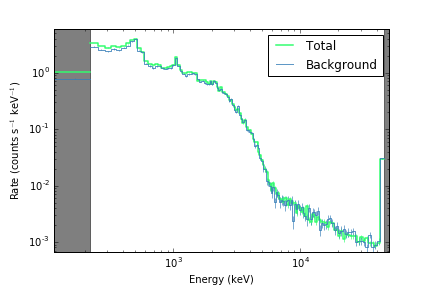

In [15]:
bgo0.set_active_measurements("250-43000")
bgo0.view_count_spectrum()

## Fitting!

We are now ready for the standard **3ML** process.

We can turn on and off effective area corrections between detectors.


In [22]:
triggerName = 'bn080916009'
ra = 121.8
dec = -61.3

data_list = DataList(nai3,nai4,bgo0 )

band = Band()

GRB = PointSource( triggerName, ra, dec, spectral_shape=band )

model = Model( GRB )

model.display()

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (4):
--------------------

                                       value min_value max_value  \
bn080916009.spectrum.main.Band.K      0.0001      None      None   
bn080916009.spectrum.main.Band.alpha      -1      -1.5         3   
bn080916009.spectrum.main.Band.xp        500        10      None   
bn080916009.spectrum.main.Band.beta       -2        -5      -1.6   

                                                 unit  
bn080916009.spectrum.main.Band.K      1 / (cm2 keV s)  
bn080916009.spectrum.main.Band.alpha                   
bn080916009.spectrum.main.Band.xp                 keV  
bn080916009.spectrum.main.Band.beta                    

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Linked parameters (0):
----------------------

(none)

In [23]:
jl = JointLikelihood( model, data_list, verbose=False )

res = jl.fit()

Best fit values:



,Best fit value,Unit
bn080916009.spectrum.main.Band.K,0.0173 +/- 0.0006,1 / (cm2 keV s)
bn080916009.spectrum.main.Band.alpha,-0.968 +/- 0.027,
bn080916009.spectrum.main.Band.beta,-5.000 +/- 0.004,
bn080916009.spectrum.main.Band.xp,369 +/- 20,keV



NOTE: errors on parameters are approximate. Use get_errors().


Correlation matrix:



1.00,0.83,-0.87,-0.00
0.83,1.00,-0.67,-0.00
-0.87,-0.67,1.00,0.00
-0.00,-0.00,0.00,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
total,3489.388722
NAI3,1086.343295
NAI4,1193.972414
BGO0,1209.073013


### Plotting the results

We can look in model and data space to examine our fit:

<IPython.core.display.Javascript object>


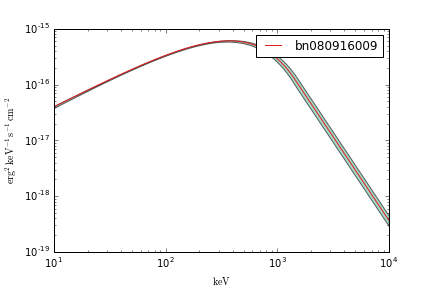

In [18]:
sp = SpectralPlotter(jl)

_=sp.plot_model(y_unit='erg2/(cm2 s keV)', num_ene=300)

We can examine our fit with the data:

<IPython.core.display.Javascript object>


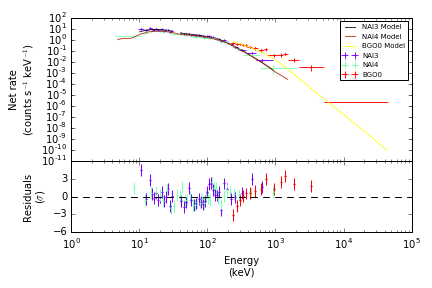

In [24]:
_ = display_ogip_model_counts(jl,min_rate=10,step=False)

<IPython.core.display.Javascript object>


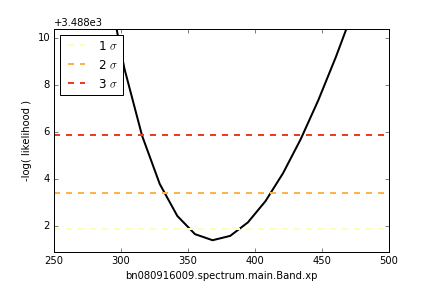

In [25]:
res = jl.get_contours(band.xp,250,500,20)

<IPython.core.display.Javascript object>


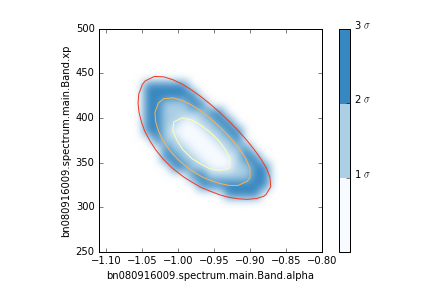

In [26]:
res = jl.get_contours(band.xp,250,500,25,band.alpha,-1.11,-.8,25)

## Time-resolved MLE analysis.

We often want to analyze the time resolved properties of a GRB. We can use the eventlist binning capabilities to bin the TTE lightcurve and then analyze these bins all at once.


We will create significance bins using the NaI3 lightcurve.


In [41]:
nai3.create_time_bins(start=0,stop=10,method='significance',sigma=30)

<IPython.core.display.Javascript object>


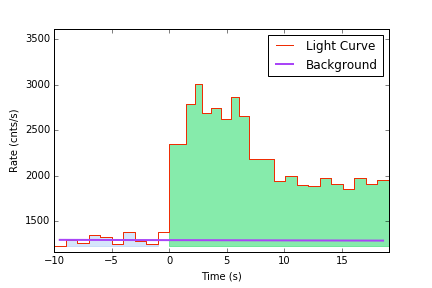

In [42]:
nai3.view_lightcurve(use_binner=True)

We must define functions to get the data and the model for the JointLikelihoodSet. For the TTE data, this means simply seting the bins we want to use.

The easiest way to acheive this is with a binner object and then a iterating through the text_bins list that is generated:


In [44]:
def data_getter(id):
    
    
    new_data = []
    
    for data in data_list.values():
        
        data.set_active_time_interval(nai3.text_bins[id])
        new_data.append(data)
    
    return DataList(*new_data)
    
    
def model_getter(id):
    
    return clone_model(model)   
    
    

Now we simply pass these functions to the JointLikelihoodSet and we can go

In [45]:
jl_set = JointLikelihoodSet(data_getter=data_getter,
                            model_getter=model_getter,
                            n_iterations=len(nai3.text_bins))


res, lh = jl_set.go(compute_covariance=True)


Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: External parameter cons_NAI3 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_NAI4 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_BGO0 already exist in the model. Overwriting it...



Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: External parameter cons_NAI3 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_NAI4 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_BGO0 already exist in the model. Overwriting it...



Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: External parameter cons_NAI3 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_NAI4 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_BGO0 already exist in the model. Overwriting it...



Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: External parameter cons_NAI3 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_NAI4 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_BGO0 already exist in the model. Overwriting it...


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in log


WARNING NotANumberInLikelihoo

Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: External parameter cons_NAI3 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_NAI4 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_BGO0 already exist in the model. Overwriting it...



Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: External parameter cons_NAI3 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_NAI4 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_BGO0 already exist in the model. Overwriting it...


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in log


WARNING NotANumberInLikelihood: These parameters returned a logLike = Nan: [ -3.00104401e+05  -9.67627274e-01   4.82941331e+03  -1.69719134e+00]


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply




Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: External parameter cons_NAI3 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_NAI4 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_BGO0 already exist in the model. Overwriting it...



Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: External parameter cons_NAI3 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_NAI4 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_BGO0 already exist in the model. Overwriting it...



Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian



WARNING RuntimeWarning: External parameter cons_NAI3 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_NAI4 already exist in the model. Overwriting it...


WARNING RuntimeWarning: External parameter cons_BGO0 already exist in the model. Overwriting it...



In [46]:
res

value        error
0 bn080916009.spectrum.main.Band.K         0.027232     0.002068
  bn080916009.spectrum.main.Band.alpha    -0.886807     0.062998
  bn080916009.spectrum.main.Band.xp      511.049696    80.229604
  bn080916009.spectrum.main.Band.beta     -4.918265     1.977154
1 bn080916009.spectrum.main.Band.K         0.039009     0.003938
  bn080916009.spectrum.main.Band.alpha    -0.891752     0.077021
  bn080916009.spectrum.main.Band.xp      444.744143    83.712405
  bn080916009.spectrum.main.Band.beta     -4.914592     2.529654
2 bn080916009.spectrum.main.Band.K         0.041828     0.003485
  bn080916009.spectrum.main.Band.alpha    -0.990709     0.066016
  bn080916009.spectrum.main.Band.xp      511.935134    96.214318
  bn080916009.spectrum.main.Band.beta     -4.810896     2.289649
3 bn080916009.spectrum.main.Band.K         0.038276     0.003266
  bn080916009.spectrum.main.Band.alpha    -0.896697     0.067669
  bn080916009.spectrum.main.Band.xp      449.763235    71.110405
  bn080916009.spectrum.main.Band.beta     -4.855834     1.700358
4 bn080916009.spectrum.main.Band.K         0.030921     0.002011
  bn080916009.spectrum.main.Band.alpha    -1.000913     0.057488
  bn080916009.spectrum.main.Band.xp      811.876820   173.367083
  bn080916009.spectrum.main.Band.beta     -2.938984     1.367867
5 bn080916009.spectrum.main.Band.K         0.028866     0.002978
  bn080916009.spectrum.main.Band.alpha    -1.028710     0.074437
  bn080916009.spectrum.main.Band.xp      779.453301   348.114158
  bn080916009.spectrum.main.Band.beta     -1.785837     0.141516
6 bn080916009.spectrum.main.Band.K         0.025957     0.001655
  bn080916009.spectrum.main.Band.alpha    -1.438138     0.049210
  bn080916009.spectrum.main.Band.xp     2547.649097  2847.735370
  bn080916009.spectrum.main.Band.beta     -2.007339     0.455154
7 bn080916009.spectrum.main.Band.K         0.022051     0.001498
  bn080916009.spectrum.main.Band.alpha    -1.435087     0.050260
  bn080916009.spectrum.main.Band.xp     1048.222152   539.696583
  bn080916009.spectrum.main.Band.beta     -2.234721     0.480290
8 bn080916009.spectrum.main.Band.K         0.017951     0.001481
  bn080916009.spectrum.main.Band.alpha    -1.281956     0.058297
  bn080916009.spectrum.main.Band.xp      481.696444   125.323460
  bn080916009.spectrum.main.Band.beta     -4.200670     4.499342

In [47]:
lh

-log(likelihood)
0 total       1587.806515
  NAI3         534.652711
  NAI4         480.839512
  BGO0         572.314291
1 total       1176.093707
  NAI3         393.504848
  NAI4         355.777590
  BGO0         426.811270
2 total        992.504092
  NAI3         347.405985
  NAI4         295.910523
  BGO0         349.187585
3 total       1217.901784
  NAI3         405.984295
  NAI4         374.384610
  BGO0         437.532878
4 total       1206.721643
  NAI3         398.954172
  NAI4         354.432368
  BGO0         453.335103
5 total       1333.390465
  NAI3         432.258217
  NAI4         407.324803
  BGO0         493.807445
6 total       1058.823911
  NAI3         362.804941
  NAI4         336.182308
  BGO0         359.836662
7 total       1199.601066
  NAI3         416.672062
  NAI4         358.822119
  BGO0         424.106886
8 total       1697.422996
  NAI3         560.212508
  NAI4         533.005003
  BGO0         604.205485

## And if you really want to be sure => Go Bayesian!

In [48]:
# First define priors
# We can do it explicitly like this:
# (be careful not to choose the boundaries outside of the allowed value
# for the parameter, according to the min_value and max_value properties)

band.K.prior = Log_uniform_prior(lower_bound=1e-4, upper_bound=3)
band.xp.prior = Log_uniform_prior(lower_bound=10, upper_bound=1e5)

# or use the set_uninformative_prior method, which will use as lower_bound
# and upper_bound the current boundaries for the parameter. Such boundaries
# must exists and be finite

band.alpha.set_uninformative_prior(Uniform_prior)
band.beta.set_uninformative_prior(Uniform_prior)

bayes = BayesianAnalysis(model, data_list)

### Sample with Affine Invariant Sampling

In [49]:
samples = bayes.sample(n_walkers=50,burn_in=200, n_samples=1000)

Running burn-in of 200 samples...


Sampling...


Mean acceptance fraction: 0.52832


<IPython.core.display.Javascript object>


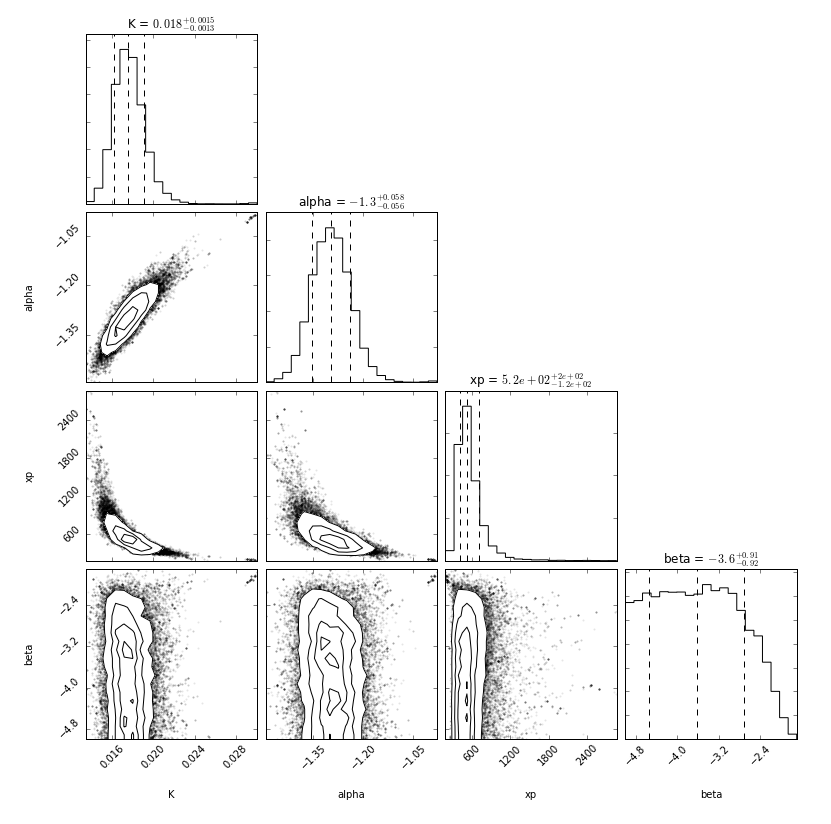

In [50]:
fig = bayes.corner_plot(plot_contours=True, plot_density=False)

### Sample with Nested Sampling (MULTINEST)

(see parallel demo for tips on parallel sampling with MPI)

In [18]:
samples = bayes.sample_multinest(n_live_points=400,resume=False)


Sampling...

MULTINEST has its own convergence criteria... you will have to wait blindly for it to finish
If INS is enabled, one can monitor the likelihood in the terminal for completion information
  analysing data from chains/fit-.txt


<IPython.core.display.Javascript object>


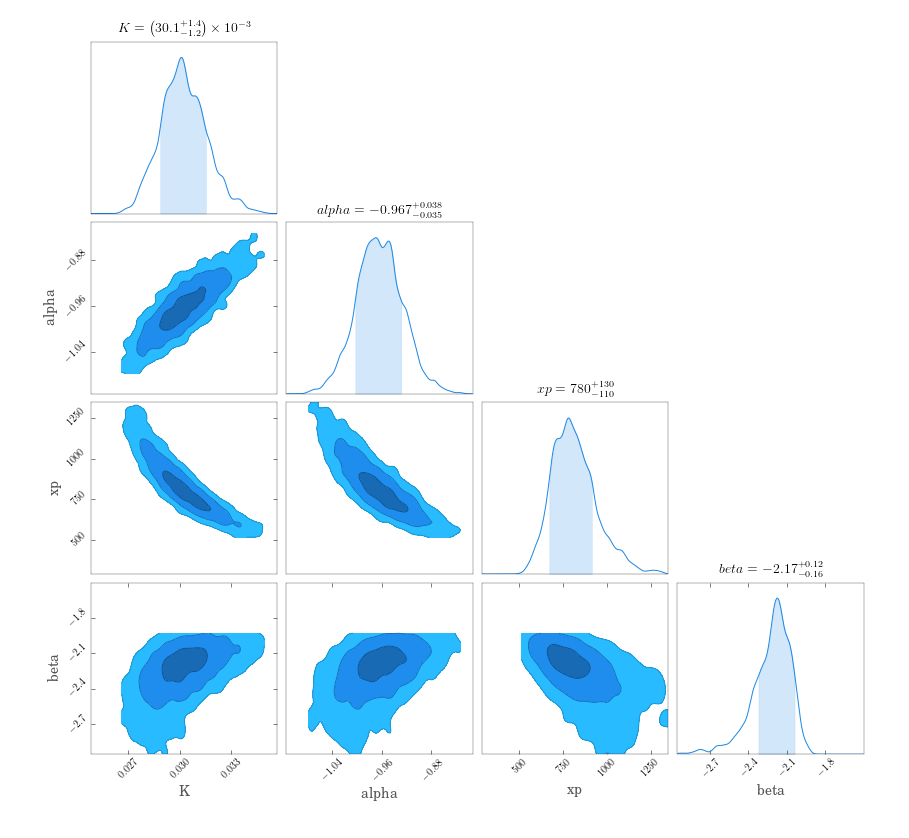

In [19]:
fig = bayes.corner_plot_cc()

#### Credible Regions

In [51]:
# equal-tailed credible regions
eq_tail = bayes.get_credible_intervals()


Name,Value,Unit
bn080916009.spectrum.main.Band.K,0.0175 -0.0007 +0.0007,1 / (cm2 keV s)
bn080916009.spectrum.main.Band.alpha,-1.297 -0.027 +0.027,
bn080916009.spectrum.main.Band.xp,(5.2 -0.6 +0.8)e+02,keV
bn080916009.spectrum.main.Band.beta,-3.6 -0.5 +0.5,



(probability 68)


In [52]:
# highest denisty intervals
hdi = bayes.get_highest_density_interval()

Name,Value,Unit
bn080916009.spectrum.main.Band.K,0.0175 -0.0028 +0.0030,1 / (cm2 keV s)
bn080916009.spectrum.main.Band.alpha,-1.30 -0.11 +0.12,
bn080916009.spectrum.main.Band.xp,(5.2 -2.4 +4)e+02,keV
bn080916009.spectrum.main.Band.beta,-3.6 -1.4 +1.3,


#### Effective free parameters (experimental)

Determine the complexity of your model and data 


In [53]:
bayes.get_effective_free_parameters()

3.4700744706756268

# PHA Exporting

While 3ML provides all the functionality needed to analyze data, it is often needed to double check results with other tools such as XSPEC. Since Fermi GBM files cannot be read into XSPEC, we provide a method export selections to a PHA file for single or multiple binnings.


### Single writeout

Any OGIP plugin has support for writing out a PHA and BAK file


In [54]:
nai3.write_pha('nai3',overwrite=True)

### Write PHA using the binning options

As shown above, we can store binning for the TTE light curve for viewing, time-resolved analysis, etc. but we can also exploit the binner to write out PHAII files with multiple selections


In [55]:
# Create the time bins
nai3.create_time_bins(0,10,method='constant',dt=1)

# Write them to a PHA file
nai3.write_pha_from_binner('nai3_binner',overwrite=True)



Auto-probed noise models:
- observation: poisson
- background: gaussian


<IPython.core.display.Javascript object>


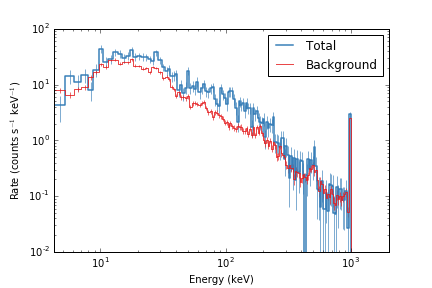

In [56]:
saved_pha = OGIPLike('test',pha_file='nai3_binner.pha{1}')

saved_pha.view_count_spectrum()

## Cleanup the data

Finally, we can remove the data if needed:

In [57]:
cleanup_downloaded_GBM_data(gbm_data)

Removing: /Users/jburgess/coding/3ML/examples/gbm/bn080916009/glg_cspec_b0_bn080916009_v00.rsp2
Removing: /Users/jburgess/coding/3ML/examples/gbm/bn080916009/glg_tte_b0_bn080916009_v01.fit.gz
Removing: /Users/jburgess/coding/3ML/examples/gbm/bn080916009/glg_cspec_n3_bn080916009_v00.rsp2
Removing: /Users/jburgess/coding/3ML/examples/gbm/bn080916009/glg_tte_n3_bn080916009_v01.fit.gz
Removing: /Users/jburgess/coding/3ML/examples/gbm/bn080916009/glg_cspec_n4_bn080916009_v00.rsp2
Removing: /Users/jburgess/coding/3ML/examples/gbm/bn080916009/glg_tte_n4_bn080916009_v01.fit.gz


